In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm
import os
import matplotlib.pyplot as plt

/mnt/c/Users/Pavan Sarvesh/tf-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
data_train_path = './dataset/newDatasetSplit/train'
data_val_path = './dataset/newDatasetSplit/val'
data_test_path = './dataset/newDatasetSplit/test'

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Datasets
train_dataset = datasets.ImageFolder(root=data_train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=data_val_path, transform=transform)
test_dataset = datasets.ImageFolder(root=data_test_path, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Class names
data_cat = train_dataset.classes
print("Classes:", data_cat)


Classes: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']


In [3]:
# Load pre-trained MobileNetV3 Small model
model = timm.create_model('mobilenetv3_small_100.lamb_in1k', pretrained=True, num_classes=len(data_cat))
model.to(device)

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): ReLU(inplace=True)
          (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (gate): Hardsigmoid()
        )
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): B

Epoch [1/10], Loss: 268.7544, Train Acc: 87.09%, Val Acc: 98.62%
Epoch [2/10], Loss: 26.2585, Train Acc: 98.67%, Val Acc: 99.05%
Epoch [3/10], Loss: 11.7490, Train Acc: 99.36%, Val Acc: 99.18%
Epoch [4/10], Loss: 9.3929, Train Acc: 99.48%, Val Acc: 99.36%
Epoch [5/10], Loss: 5.1680, Train Acc: 99.77%, Val Acc: 99.54%
Epoch [6/10], Loss: 6.0121, Train Acc: 99.75%, Val Acc: 99.56%
Epoch [7/10], Loss: 7.0614, Train Acc: 99.65%, Val Acc: 99.85%
Epoch [8/10], Loss: 4.6624, Train Acc: 99.77%, Val Acc: 98.79%
Epoch [9/10], Loss: 7.8005, Train Acc: 99.61%, Val Acc: 99.72%
Epoch [10/10], Loss: 8.6830, Train Acc: 99.56%, Val Acc: 98.79%


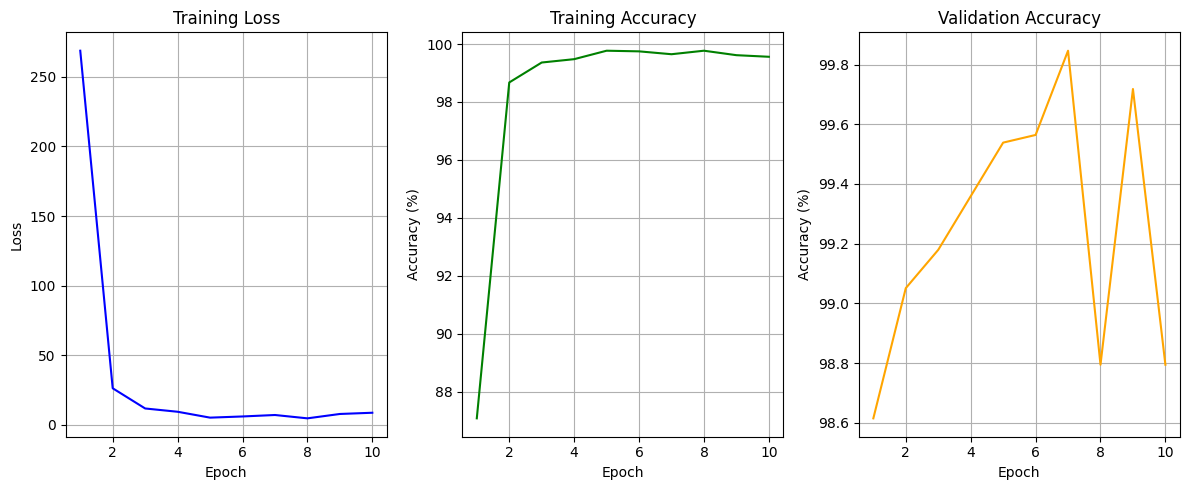

In [9]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 10
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses.append(total_loss)
    train_accuracies.append(train_acc)

    model.eval()
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# Save model
torch.save(model.state_dict(), 'mobilenetv3_old_tamil.pth')

# Plot results
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Training Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

# Validation Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs_range, val_accuracies, label='Val Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Load trained model
model.load_state_dict(torch.load('mobilenetv3_old_tamil.pth'))
model.eval()

all_preds = []
all_labels = []

# Evaluate on test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy:  {accuracy * 100:.2f}%")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall:    {recall:.4f}")
print(f"Test F1 Score:  {f1:.4f}")

# Optional: Detailed per-class report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=data_cat))


Test Accuracy:  98.96%
Test Precision: 0.9901
Test Recall:    0.9896
Test F1 Score:  0.9895

Classification Report:
              precision    recall  f1-score   support

          00       1.00      1.00      1.00       151
          01       0.96      1.00      0.98       151
          02       1.00      0.99      1.00       151
          03       1.00      1.00      1.00       151
          04       1.00      1.00      1.00       151
          05       0.92      1.00      0.96       151
          06       0.99      1.00      1.00       151
          07       0.98      0.85      0.91       151
          08       1.00      1.00      1.00       151
          09       1.00      1.00      1.00       151
          10       1.00      0.97      0.99       151
          11       1.00      0.99      0.99       151
          12       0.91      1.00      0.95       151
          13       1.00      0.97      0.98       151
          14       0.99      1.00      0.99       151
          15       

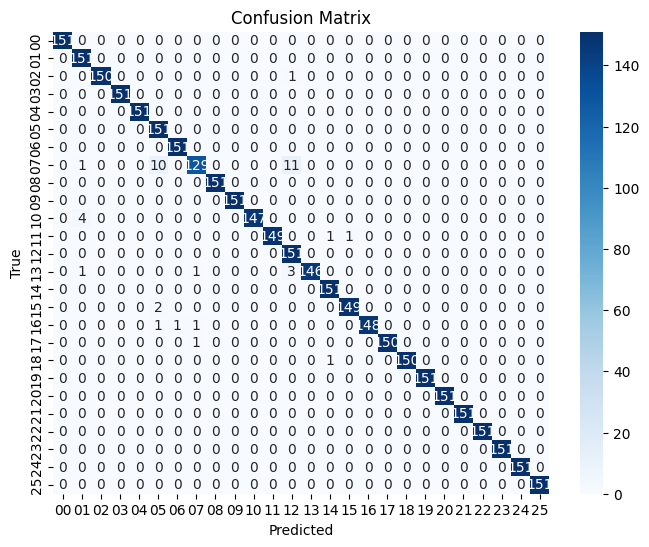

In [5]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load trained model
model.load_state_dict(torch.load('./mobilenetv3_old_tamil.pth'))
model.eval()

all_preds = []
all_labels = []

# Evaluate on test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data_cat, yticklabels=data_cat)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
from PIL import Image

# Function to load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Load model weights
model.load_state_dict(torch.load('mobilenetv3_old_tamil.pth'))
model.eval()

# Path to test image
test_image_path = './character_segments/char_12.png'  # <- Replace with your actual image path
input_image = preprocess_image(test_image_path)

# Make prediction
with torch.no_grad():
    output = model(input_image)
    _, predicted = torch.max(output, 1)

# Output result
predicted_class = data_cat[predicted.item()]
print(f"Predicted Class: {predicted_class}")


Predicted Class: 07


Prediction Accuracy: 88.34%


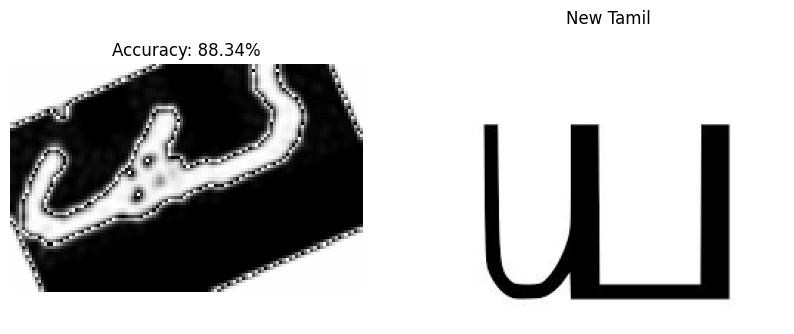

In [5]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Category names (update this with your actual label list)

# Load the model (MobileNetV3, for example)
import timm
model = timm.create_model('mobilenetv3_small_100.lamb_in1k', pretrained=False, num_classes=len(data_cat))
model.load_state_dict(torch.load('mobilenetv3_old_tamil.pth', map_location=device))
model = model.to(device)
model.eval()

# Image preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Load and preprocess the test image
test_image_path = './character_segments/inverted_39_aug70.png'
input_image = preprocess_image(test_image_path)

# Predict
with torch.no_grad():
    output = model(input_image)
    probabilities = nn.functional.softmax(output[0], dim=0)
    confidence, predicted_idx = torch.max(probabilities, dim=0)

predicted_class = data_cat[predicted_idx.item()]
accuracy = confidence.item() * 100
# print(f"Predicted Class: {predicted_class}")
print(f"Prediction Accuracy: {accuracy:.2f}%")

# Display the input and output images side-by-side
plt.figure(figsize=(10, 5))

# Original input image
plt.subplot(1, 2, 1)
original_image = Image.open(test_image_path)
plt.imshow(original_image)
plt.axis('off')
plt.title(f"Accuracy: {accuracy:.2f}%")

# Corresponding reference image
ref_image_path = f'./dataset/OneDrive_2025-03-20/New mapping/{predicted_class}/{predicted_class}.png'
if os.path.exists(ref_image_path):
    ref_image = Image.open(ref_image_path)
    plt.subplot(1, 2, 2)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title("New Tamil")
else:
    print("Reference image not found.")

plt.show()
